In [128]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import missingno as msno
import warnings

import math
from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')
# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
warnings.filterwarnings('ignore')

In [129]:
df = pd.read_csv("students_df_cleaned.csv")


In [130]:
df.head()


,Unnamed: 0,tottr,hhmem,mode_category,trip_distance_miles,city_from_zip,gender,age,citizen,driver_license,...,transmission,cylinders,veh_type,departure_datetime,departure_hour,day_of_week,month,season,is_weekend,time_of_day
0,0,3.0,1.0,Auto Passenger,3.619057,Greater Los Angeles Area,1.0,15.0,1.0,2.0,...,0.0,0.0,0.0,2012-05-12 11:10:00,11,Saturday,May,Spring,Weekend,Morning
1,1,3.0,1.0,Auto Passenger,2.545849,Greater Los Angeles Area,1.0,15.0,1.0,2.0,...,0.0,0.0,0.0,2012-05-12 11:31:00,11,Saturday,May,Spring,Weekend,Morning
2,2,3.0,1.0,Auto Passenger,1.961798,Greater Los Angeles Area,1.0,15.0,1.0,2.0,...,0.0,0.0,0.0,2012-05-12 11:52:00,11,Saturday,May,Spring,Weekend,Morning
3,3,5.0,4.0,Auto Passenger,3.587950,Greater Los Angeles Area,1.0,15.0,1.0,2.0,...,0.0,0.0,0.0,2012-05-12 15:30:00,15,Saturday,May,Spring,Weekend,Afternoon
4,4,3.0,2.0,Auto Passenger,3.619057,Greater Los Angeles Area,1.0,14.0,1.0,2.0,...,0.0,0.0,0.0,2012-05-12 08:15:00,8,Saturday,May,Spring,Weekend,Morning


In [131]:
# Select non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=['number']).columns.tolist()

# Print the non-numeric columns
print("Non-numeric columns:")
print(non_numeric_columns)

Non-numeric columns:
['mode_category', 'city_from_zip', 'model_year', 'departure_datetime', 'day_of_week', 'month', 'season', 'is_weekend', 'time_of_day']


In [132]:
# check for numeric values 
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

print("Numeric columns:")
print(numeric_columns)

Numeric columns:
['Unnamed: 0', 'tottr', 'hhmem', 'trip_distance_miles', 'gender', 'age', 'citizen', 'driver_license', 'transit_pass', 'car_sharing', 'commute_mode', 'disabled', 'transit_trip', 'transit_subsidy', 'walk_trips', 'bike_trips', 'student', 'school_grade', 'education', 'person_trips', 'HOVL', 'Moto_trip', 'race', 'incentive', 'vehicle_count', 'bike_count', 'residence_type', 'home_own', 'income', 'persons_count', 'worker_count', 'student_count', 'license_count', 'trip_count', 'WMO_code', 'temperature_2m_max (°C)', 'temperature_2m_min (°C)', 'temperature_2m_mean (°C)', 'apparent_temperature_mean (°C)', 'daylight_dur (s)', 'total_ precip (mm)', 'rain (mm)', 'snowfall (cm)', 'precip_hours (h)', 'body_type', 'fuel_type1', 'purchase_type', 'ownership', 'transmission', 'cylinders', 'veh_type', 'departure_hour']


In [133]:
print(pd.to_datetime(df['departure_datetime']))

0       2012-05-12 11:10:00
1       2012-05-12 11:31:00
2       2012-05-12 11:52:00
3       2012-05-12 15:30:00
4       2012-05-12 08:15:00
                ...        
40697   2013-01-22 18:13:00
40698   2013-01-30 07:24:00
40699   2013-01-30 12:55:00
40700   2013-01-30 13:26:00
40701   2013-01-21 15:20:00
Name: departure_datetime, Length: 40702, dtype: datetime64[ns]


In [134]:
print(df['mode_category'].unique())

['Auto Passenger' 'Active Transportation' 'Transit' 'Auto Driver']


In [135]:
# no indivator for motor (auto) tipse! 

print(df['Moto_trip'].unique())

[ 1.  2. nan]


In [136]:
df = df.dropna(subset=['Moto_trip'])

In [142]:
print(df['HOVL'].unique())

[ 1.  2. nan 98. 99.]


In [143]:
print(df['HOVL'].value_counts())

HOVL
2.0     33087
1.0      2263
98.0      415
99.0        8
Name: count, dtype: int64


In [144]:
df['HOVL'] = df['HOVL'].fillna(2)
df['HOVL'] = df['HOVL'].replace([99, 98], 2)

In [ ]:
# # not functioning 
# def bin_model_year(year):
#     if year == 0:
#         return 'No Car'
#     elif year < 2000:
#         return 'Before 2000'
#     elif 2000 <= year <= 2013:
#         return '2000-2013'
#     else:
#         return 'Unknown'
# df['model_year_binned'] = df['model_year'].apply(bin_model_year)

In [ ]:
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

In [ ]:
def selected_feature(data):
    
    # Temporal Features from time 
    # we arent using Unix time since I think that causes too much overfitting and the test data starts in 2010
    # accounts for daily peaks etxx.
    data['Hour'] = pd.to_datetime(data['departure_datetime']).dt.hour
    # accounts for the fluxuations between start/end of month behavior
    data['Day_of_Month'] = pd.to_datetime(data['departure_datetime']).dt.day
    # accounts for the shifts in ridership between months
    data['Month'] = pd.to_datetime(data['departure_datetime']).dt.month
    # accounts for changes / growth or decrease over years 
    data['Year'] = pd.to_datetime(data['departure_datetime']).dt.year
    # accounts for weekend/weekday fluxuations
    data['Weekday'] = pd.to_datetime(data['departure_datetime']).dt.weekday   # 0-6 (Mon-Sun)
    # since its very seasonal lets put in the seaons! 
    # Define the seasons based on the month
    seasons = {
        1: 1, 2: 1, 12: 1, # winter (1)
        3: 2, 4: 2, 5: 2, # spring (2)
        6: 3, 7: 3, 8: 3, #summer (3)
        9: 4, 10: 4, 11: 4 #fall (4)
    }

    # Apply the season logic to the month column 
    data['Season'] = data['Month'].map(seasons)

    
    # code doenst work and it doesnt matter 
    # data['time_of_day'] = data['Hour'].apply(get_time_of_day)


    feature_selected = ['license_count', 'trip_count', 'WMO_code', 'temperature_2m_max (°C)', 'temperature_2m_min (°C)', 'temperature_2m_mean (°C)', 'apparent_temperature_mean (°C)', 'daylight_dur (s)', 'total_ precip (mm)', 'rain (mm)', 'snowfall (cm)', 'precip_hours (h)', 'body_type', 'fuel_type1', 'purchase_type', 'ownership', 'transmission', 'cylinders', 'veh_type']

    selected_data = data[feature_selected]
    
    return selected_data

In [ ]:
'license_count', 'trip_count', 'WMO_code', 'temperature_2m_max (°C)', 'temperature_2m_min (°C)', 'temperature_2m_mean (°C)', 'apparent_temperature_mean (°C)', 'daylight_dur (s)', 'total_ precip (mm)', 'rain (mm)', 'snowfall (cm)', 'precip_hours (h)', 'body_type', 'fuel_type1', 'purchase_type', 'ownership', 'transmission', 'cylinders', 'veh_type', 'departure_hour'

In [ ]:
feature_selected = ['tottr', 
                        'gender',
                        'race', #skew data or w/e 
                        'age',
                        # 'incentive', # does not exist 
                        'vehicle_count', 'bike_count', # possible overfit here so added friends
                        #'residence_type', # this is scuffed varible might need alt encoding     
                        'school_grade', 
                        'income',
                        'citizen', # international vs local ? USA regional differances? 
                        'driver_license',
                        'apparent_temperature_mean (°C)',
                        'WMO_code', # alternative encoding maybe?
                        'Hour',
                        'Day_of_Month',
                        'Month',
                        'Weekday',
                        'Season',
                        'Moto_trip', # y/n used mtoor on prev travel trip?
                        # 'time_of_day' # in hour 
                        
                        # alterantives to add (1)
                        'persons_count', 'worker_count', 'student_count', #- for family distibution etxx 
                        # 'education', 'person_trips', - edu overfit with school grade (kinda0)
                        'transit_trip', 'walk_trips', 'bike_trips', # attached histoical data for these individuals (week)
                        'HOVL',# for differnation between passenger vs non passengers  BUT IS SKEW ! ! ! !
                        'ownership' # differnce in behavior as car own ?
                        ]

In [197]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# Assume df is your DataFrame and 'y' is the target column

# Step 1: Split the data into data (70%) and temp (30%)
data_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['mode_category'], random_state=42)

# Step 2: Split the temp set into validation (15%) and test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['mode_category'], random_state=42)

# Step 3: Separate features (X) and target (y) for the dataing set
X_data = selected_feature(data_df)
y_data = data_df['mode_category']

# Step 4: Apply SMOTE to the dataing set
smote = SMOTE(random_state=42)
X_data_resampled, y_data_resampled = smote.fit_resample(X_data, y_data)

# Step 5: Print class distribution after SMOTE
print("Class distribution before SMOTE:", Counter(y_data))
print("Class distribution after SMOTE:", Counter(y_data_resampled))

# Step 6: Separate features and target for validation and test sets
X_val = selected_feature(val_df)
y_val = val_df['mode_category']

X_test = selected_feature(test_df)
y_test = test_df['mode_category']

# Outputs
print(f"dataing set size: {X_data_resampled.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Class distribution before SMOTE: Counter({'Auto Passenger': 19016, 'Active Transportation': 4952, 'Auto Driver': 2889, 'Transit': 1497})
Class distribution after SMOTE: Counter({'Auto Passenger': 19016, 'Auto Driver': 19016, 'Transit': 19016, 'Active Transportation': 19016})
dataing set size: 76064
Validation set size: 6076
Test set size: 6077


In [198]:
model = RandomForestClassifier(random_state=42)

# Fit and predict
model.fit(X_data_resampled, y_data_resampled)

RandomForestClassifier(random_state=42)

In [199]:
y_pred = model.predict(X_val)

#### Check the performance of the model

In [200]:
accuracy = accuracy_score(y_val, y_pred)

print(f"Accuracy of the Random Forest Classifier: {accuracy * 100:.2f}%")

Accuracy of the Random Forest Classifier: 78.39%


In [201]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(model, X_data_resampled, y_data_resampled, cv=5)

print(f"Cross-Validated Accuracy: {cv_scores.mean() * 100:.2f}%")

Cross-Validated Accuracy: 86.84%


In [202]:
from sklearn.metrics import classification_report, f1_score

# Step 1: Check class distribution
unique, counts = np.unique(y_val, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)

# Step 2: Generate classification report
report = classification_report(y_val, y_pred, target_names=['Auto Passenger', 'Active Transportation', 'Transit' ,'Auto Driver'], digits=3)
print("\nClassification Report:\n", report)

# Step 3: Calculate weighted F1-score
weighted_f1 = f1_score(y_val, y_pred, average='weighted')
print("\nWeighted F1-Score:", weighted_f1)

Class Distribution: {'Active Transportation': 1061, 'Auto Driver': 619, 'Auto Passenger': 4075, 'Transit': 321}

Classification Report:
                        precision    recall  f1-score   support

       Auto Passenger      0.543     0.523     0.533      1061
Active Transportation      0.783     0.842     0.812       619
              Transit      0.890     0.881     0.886      4075
          Auto Driver      0.268     0.296     0.281       321

             accuracy                          0.784      6076
            macro avg      0.621     0.636     0.628      6076
         weighted avg      0.786     0.784     0.785      6076


Weighted F1-Score: 0.7847448314606913


When Precision is More Important

Definition: Precision measures the proportion of predicted trips in a mode that are correctly classified.
    Relevant When:
        You want to minimize false positives for a specific mode.
        Example: If the model predicts a trip as Transit, but it’s actually not, this could lead to overestimating infrastructure needs (e.g., buses, routes) and misallocating resources.
        Use Case:
            Planning for infrastructure investment (e.g., transit systems, bike lanes) where misclassifications could lead to costly overbuilds.

When Recall is More Important

Definition: Recall measures the proportion of actual trips in a mode that are correctly identified.
    Relevant When:
        You want to ensure that all trips of a certain mode are identified, even if there are false positives.
        Example: If the model under-predicts Transit trips, you might miss opportunities to serve these travelers, resulting in inadequate public transport capacity or service.
        Use Case:
            Identifying underserved modes or ensuring inclusivity in mode-specific policies (e.g., active transport like walking and cycling).

When F1-Score is More Important

Definition: The F1-score is the harmonic mean of precision and recall, balancing the two.
    Relevant When:
        Both false positives and false negatives are costly or have policy implications.
        Example: Accurately modeling all modes (e.g., Auto, Transit, Active Transport) is equally critical for balanced urban planning.

if the focus is resource allocation or specific mode-specific investments, precision for that mode becomes critical. (planning or us


Top 10 Important Features:
                           Feature  Importance
19                  departure_hour    0.110828
1                       trip_count    0.107802
7                 daylight_dur (s)    0.096757
3          temperature_2m_max (°C)    0.075595
4          temperature_2m_min (°C)    0.075247
6   apparent_temperature_mean (°C)    0.073399
0                    license_count    0.072696
5         temperature_2m_mean (°C)    0.072156
2                         WMO_code    0.048429
16                    transmission    0.044181
14                   purchase_type    0.041450
15                       ownership    0.037993
18                        veh_type    0.028774
17                       cylinders    0.025649
12                       body_type    0.023799
13                      fuel_type1    0.021498
9                        rain (mm)    0.014228
8               total_ precip (mm)    0.014150
11                precip_hours (h)    0.013924
10                   snowfall (c

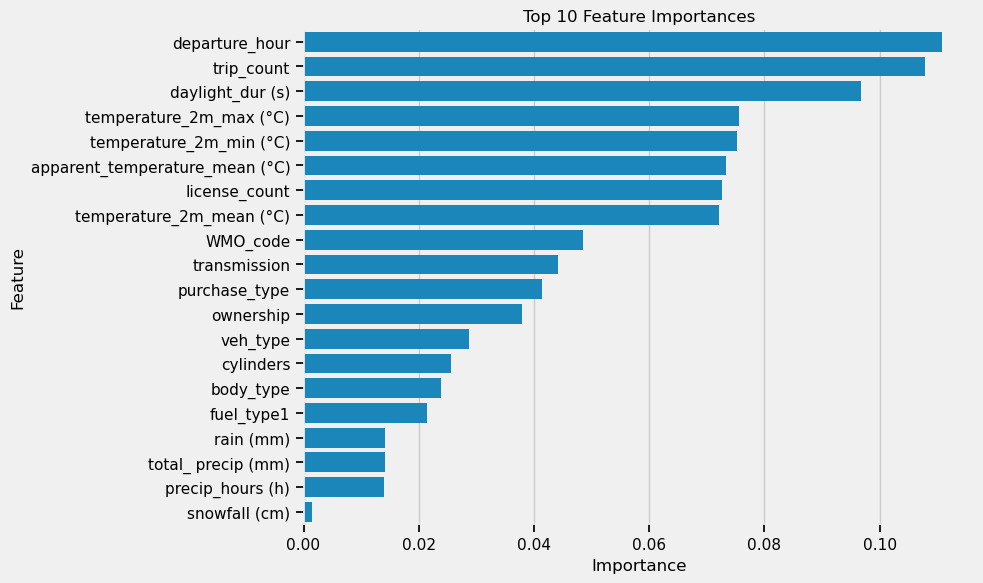

In [205]:
# Feature importances
importances = model.feature_importances_
feature_names = X_data.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
print("\nTop 10 Important Features:")
print(feature_importance_df.head(100))

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(100))
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()